In [1]:
import synpivimage as spi 
spi.__version__

from pprint import pprint
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pyplot as plt

In [2]:
def plot_img(img, ax, **kwargs):
    im = ax.imshow(img, cmap='gray', **kwargs)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cb = plt.colorbar(im, cax=cax)

In [3]:
cfg = spi.config.SynPivConfig(
    ny=100,
    nx=100,
    bit_depth=8,
    dark_noise=0,
    image_particle_peak_count=200,
    laser_shape_factor=2,
    laser_width=2,
    noise_baseline=0,
    particle_number=int(0.1*100*100),
    particle_position_file='mypositions.txt',
    particle_size_illumination_dependency=True,
    particle_size_mean=2.5,
    particle_size_std=0,
    qe=1.,
    sensitivity=1.,
    shot_noise=True,
    square_image=True)
cfg

SynPivConfig(ny=100, nx=100, square_image=True, bit_depth=8, noise_baseline=0.0, dark_noise=0.0, shot_noise=True, sensitivity=1.0, qe=1.0, particle_number=1000, particle_size_mean=2.5, particle_size_std=0.0, laser_width=2, laser_shape_factor=2, image_particle_peak_count=200, particle_position_file='mypositions.txt', particle_size_illumination_dependency=True)

In [4]:
cfg.particle_size_mean

2.5

In [5]:
out_of_plane_fraction = 0.5

In [6]:
imgA, _, partA = spi.generate_image(
    cfg
)

imgB, _, partB = spi.generate_image(
    cfg,
    particle_data=partA.displace(cfg, dx=0, dy=0, dz=out_of_plane_fraction*cfg.laser_width)
)

Laser zmin: -1.0, zmax: 1.0
Current zmin: -0.9992897693101899, zmax: 0.9977801828420936
dz 1.0 znew_min 0.0007102306898101318 znew_max 1.9977801828420936
Lost particles: 511 (51.1 %)
Number of particles inside the laser sheet: 1000
ppp: 0.1


In [7]:
# partB.size

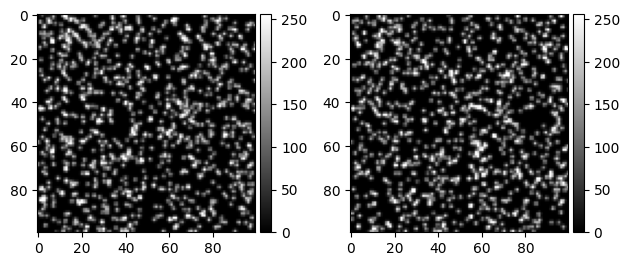

In [8]:
fig, axs = plt.subplots(1, 2)
plot_img(imgA, axs[0], vmax=2**cfg.bit_depth)
plot_img(imgB, axs[1], vmax=2**cfg.bit_depth)
plt.tight_layout()
plt.show()

# Out of plane effect - zoom to an interrogation window

Let's investigate a few particles, e.g. 6, inside an IA:

In [9]:
cfg.particle_number = 6
cfg.nx = 16
cfg.ny = 16
cfg.particle_size_mean = 2.5
cfg.particle_size_std = 0
cfg.laser_width = 1
cfg.particle_density()

0.0234375

In [221]:
xtrue = 0.6
ytrue = 0.3

imgsA = []
imgsB = []
for _ in range(100):
    imgA, _, partA = spi.generate_image(
        cfg
    )
    
    imgB, _, partB = spi.generate_image(
        cfg,
        particle_data=partA.displace(
            cfg, dx=xtrue, dy=ytrue, dz=0.0*cfg.laser_width)
    )
    imgsA.append(imgA)
    imgsB.append(imgB)
imgsA = np.stack(imgsA, 0)
imgsB = np.stack(imgsB, 0)

Laser zmin: -0.5, zmax: 0.5
Current zmin: -0.36632252647186414, zmax: 0.3534311895451945
dz 0.0 znew_min -0.36632252647186414 znew_max 0.3534311895451945
Lost particles: 0 (0.0 %)
Number of particles inside the laser sheet: 5
ppp: 0.01953125
Laser zmin: -0.5, zmax: 0.5
Current zmin: -0.22813368795521294, zmax: 0.3022683718672491
dz 0.0 znew_min -0.22813368795521294 znew_max 0.3022683718672491
Lost particles: 0 (0.0 %)
Number of particles inside the laser sheet: 6
ppp: 0.0234375
Laser zmin: -0.5, zmax: 0.5
Current zmin: -0.34088500316203985, zmax: 0.40785316832582774
dz 0.0 znew_min -0.34088500316203985 znew_max 0.40785316832582774
Lost particles: 0 (0.0 %)
Number of particles inside the laser sheet: 5
ppp: 0.01953125
Laser zmin: -0.5, zmax: 0.5
Current zmin: -0.24449376319279492, zmax: 0.4006819791157378
dz 0.0 znew_min -0.24449376319279492 znew_max 0.4006819791157378
Lost particles: 0 (0.0 %)
Number of particles inside the laser sheet: 5
ppp: 0.01953125
Laser zmin: -0.5, zmax: 0.5
Cur

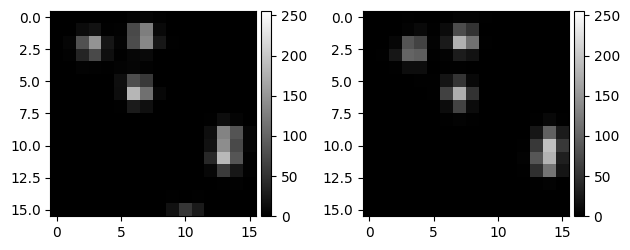

In [222]:
fig, axs = plt.subplots(1, 2)
plot_img(imgsA[3, ...], axs[0], vmax=2**cfg.bit_depth)
plot_img(imgsB[3, ...], axs[1], vmax=2**cfg.bit_depth)
plt.tight_layout()
plt.show()

In [223]:
from scipy.fft import rfft2, irfft2, fftshift
import numpy as np

In [224]:
def get_corr_plane(imgA, imgB):
    f2a = np.conj(rfft2(imgA))
    f2b = rfft2(imgB)
    corr = fftshift(irfft2(f2a * f2b).real, axes=(-2, -1))
    return corr

def get_integer_peak(corr):
    ind = corr.ravel().argmax(-1)
    peaks = np.array(np.unravel_index(ind, corr.shape[-2:]))

    peaks = np.vstack((peaks[0], peaks[1])).T
    index_list = [(i, v[0], v[1]) for i, v in enumerate(peaks)]
    peaks_max = np.nanmax(corr, axis = (-2, -1))

    # np.array(index_list), np.array(peaks_max)
    iy, ix = index_list[0][2], index_list[0][1]
    return iy, ix

def get_sub_peak_position(_corr):
    eps =1e-7
    corr = _corr + eps
    subp_peak_position = (np.nan, np.nan)
    peak1_i = peak1_indexndex[1]
    peak1_j = peak1_indexndex[2]

    c = corr[peak1_i, peak1_j]
    cl = corr[peak1_i - 1, peak1_j]
    cr = corr[peak1_i + 1, peak1_j]
    cd = corr[peak1_i, peak1_j - 1]
    cu = corr[peak1_i, peak1_j + 1]

    nom1 = np.log(cl) - np.log(cr)
    den1 = 2 * np.log(cl) - 4 * np.log(c) + 2 * np.log(cr)
    nom2 = np.log(cd) - np.log(cu)
    den2 = 2 * np.log(cd) - 4 * np.log(c) + 2 * np.log(cu)
    
    subp_peak_position = (
        peak1_i + np.divide(nom1, den1, out=np.zeros(1),
                            where=(den1 != 0.0))[0],
        peak1_j + np.divide(nom2, den2, out=np.zeros(1),
                            where=(den2 != 0.0))[0],
    )
    return subp_peak_position

In [225]:
corr = get_corr_plane(imgsA[0], imgsB[0])
iyINT, ixINT = get_integer_peak(corr)

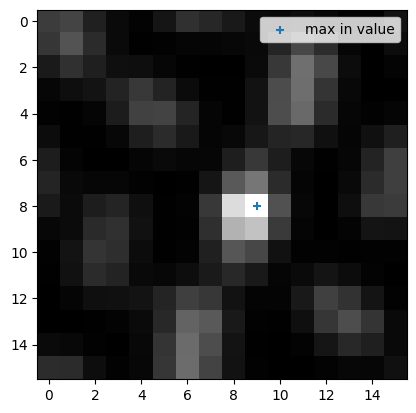

In [226]:
plt.imshow(corr, cmap='gray')
plt.scatter(iyINT, ixINT, marker='+', label='max in value')
plt.legend()

Determination of subpixel peak location (gaussian)

In [227]:
def gauss(x, x0, k, C):
    return C*np.exp((-(x0-x)**2)/k)

In [228]:
from scipy.optimize import curve_fit

In [229]:
def plot_subpeak(R3, peak_loc, ax=None, color=None):
    """R3 = R[-1], R[0], R[1]"""
    if ax is None:
        ax = plt.gca()
    popt, pcov = curve_fit(gauss, [-1, 0, 1], R3)
    ax.scatter([-1, 0, 1], R3, color=color)
    _x = np.linspace(-2, 2, 101)
    g = gauss(_x, *popt)
    ax.plot(_x, g, color=color)
    ax.scatter(peak_loc, g.max(), marker='x', color=color)
    return ax

C:\Users\da4323\Anaconda3\envs\piv\lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


displacement: dy=0.18, nx=0.64
x err: 0.036, y err: 0.123


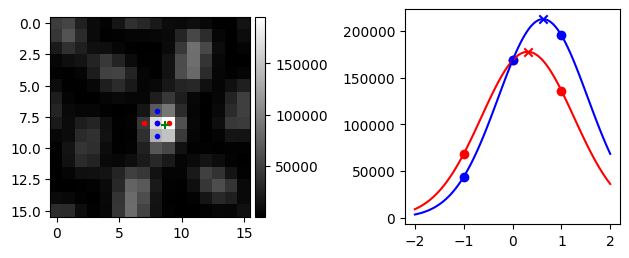

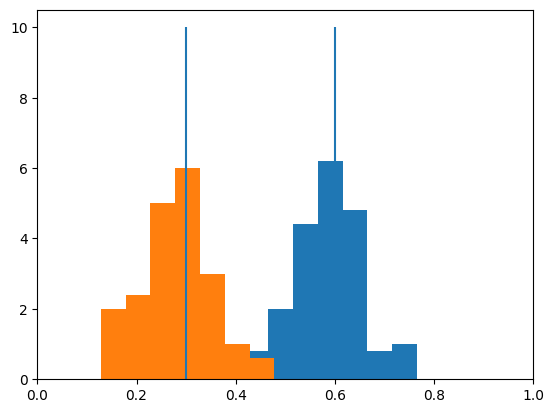

In [232]:
fig, axs = plt.subplots(1, 2)
plot_img(corr, axs[0])
# axs[0].scatter(peak1_i, peak1_j,
#                marker='+', label='max in value')
# axs[1].plot([-1,0,1], [cl, c, cr], 'b--')
# axs[1].plot([-1,0,1], [cd, c, cu], 'r--')
axs[0].scatter([peak1_j-1, peak1_j, peak1_j+1],
               [peak1_i, peak1_i, peak1_i],
               color='r', marker='.')
axs[0].scatter([peak1_j, peak1_j, peak1_j],
               [peak1_i-1, peak1_i, peak1_i+1],
              color='b', marker='.')
axs[0].scatter(subp_peak_position[1], subp_peak_position[0],
              color='g', marker='+')

c = corr[peak1_i, peak1_j]
cl = corr[peak1_i - 1, peak1_j]
cr = corr[peak1_i + 1, peak1_j]
cd = corr[peak1_i, peak1_j - 1]
cu = corr[peak1_i, peak1_j + 1]

ipeak, jpeak = get_sub_peak_position(corr)

plot_subpeak([cl, c, cr], peak_loc=ipeak-cfg.nx/2, ax=axs[1], color='r')
plot_subpeak([cd, c, cu], peak_loc=jpeak-cfg.ny/2, ax=axs[1], color='b')
asp = np.diff(axs[1].get_xlim())[0] / np.diff(axs[1].get_ylim())[0]
axs[1].set_aspect(asp)

plt.tight_layout()

dy = subp_peak_position[0] - cfg.ny/2
dx = subp_peak_position[1] - cfg.nx/2
print(f'displacement: dy={dy:.2f}, nx={dx:.2f}')
dx_err = np.abs(dx-xtrue)
dy_err = np.abs(dy-ytrue)
print(f'x err: {dx_err:.3f}, y err: {dy_err:.3f}')

n_imgs = imgsA.shape[0]

dxs, dys = [], []
for i in range(n_imgs):
    _corr = get_corr_plane(imgsA[i, ...], imgsB[i, ...])
    subp_peak_position = get_sub_peak_position(_corr)
    dys.append(subp_peak_position[0] - cfg.ny/2)
    dxs.append(subp_peak_position[1] - cfg.nx/2)


binwidth = 0.05
plt.figure()
bins = np.arange(np.nanmin(dxs), np.nanmax(dxs) + binwidth, binwidth)
plt.hist(dxs, density=True, bins=bins)

bins = np.arange(np.nanmin(dys), np.nanmax(dys) + binwidth, binwidth)
plt.hist(dys, density=True, bins=bins)
plt.vlines(xtrue, 0, 10)
plt.vlines(ytrue, 0, 10)
plt.xlim(0, 1)
plt.show()